# Análise topológica de sinais de ECG via imersão de Takens

## Objetivo

Este notebook tem como objetivo realizar a leitura, visualização e análise de sinais ECG provenientes de múltiplos pacientes. 
Os dados estão armazenados em arquivos no formato `.edf`, onde cada arquivo corresponde ao registro de um paciente.
Após leitura geraremos uma nova série temporal a partir do ECG que terá como amplitudes as distâncias entre os picos R-R.
Esta nova série temporal será imersa no plano cartesiano como uma nuvem de pontos através da imersão de Takens.
Finalmente, a partir desta nuvem será gerado um diagrama de persistência homológica utilizando a filtração de Vietoris-Rips.

## Estrutura do Programa

1. **Importação de Bibliotecas**  
   Utilizaremos a biblioteca `mne` para manipular e processar os arquivos `.edf`, além de outras bibliotecas auxiliares, caso necessário.

2. **Leitura dos Arquivos EDF**  
   O programa irá carregar os arquivos contendo os sinais ECG, extraindo os dados brutos e as informações associadas, como frequência de amostragem, nomes dos canais e duração do registro.

3. **Visualização dos Sinais**  
   Para facilitar a análise inicial, os sinais serão plotados para inspeção manual.

4. **Extração e processamento**
   Os sinais serão convertidos para matrizes NumPy, permitindo a detecção de picos. Isto dará origem a uma nova série temporal cujas amplitudes serão as distâncias (em segundos) entre os picos R-R.

6. **Takens embedding**
   A imersão será realizada em um plano cartesiano. Ao final obteremos uma nuvem de pontos associada à série temporal de distâncias entre picos R-R com d=2 e delay=1

8. **Topological data analysis**
   Obtida a nuvem de pontos geraremos um diagrama de persistência utilizando filtração Vietoris-Rips
   
10. **Salvando dados a cada execução**
    Salvaremos os dados de forma acumulativa em um arquivo do tipo .json. Serão salvos o nome do arquivo e o diagrama em forma de dicionario automaticamente.

## Formato dos arquivos

- **Arquivos de entrada**: Arquivos no formato `.edf`, um para cada paciente.
- **Conteúdo dos arquivos de entrada**: Sinais de ECG gravados em múltiplos canais, acompanhados de metadados como frequência de amostragem, nome etc.
- **Saída**: Arquivo do tipo .json contendo os nomes dos arquivos .edf e os diagramas de persistencia associados. Será usada uma estrutura de dicionário onde o nome será a chave e o diagrama (em formato array) será o conteúdo. 

---

**Nota**: Certifique-se instalar as bibliotecas necessarias antes de executar o programa: por exemplo, pip install matplotlib, pip install giotto-tda, etc.

Extracting EDF parameters from C:\Users\dddsi\projetospython\ECG_projeto1\Aloisio_LION_Baseline.OA_PROGRAMA_A_DESLIGADO.28-03-2022 14.57.29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 44399  =      0.000 ...   147.997 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: F3, F4, FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, ...
 chs: 28 EEG
 custom_ref_applied: False
 highpass: 0.1 Hz
 lowpass: 70.0 Hz
 meas_date: 2022-03-28 14:58:07 UTC
 nchan: 28
 projs: []
 sfreq: 300.0 Hz
 subject_info: <subject_info | his_id: X, sex: 1, last_name: Aloisio_LION_Baseline_OA_PROGRAMA_A_DESLIGADO, birthday: 1900-01-01>
>


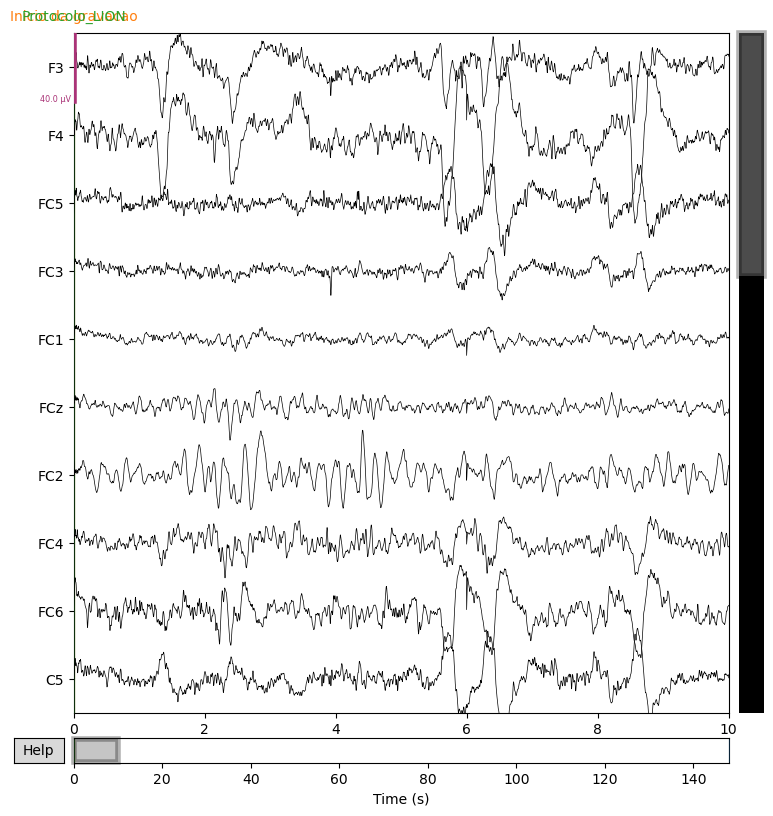

Formato dos dados: (28, 44400)
Primeiros 5 tempos: [0.         0.00333333 0.00666667 0.01       0.01333333]


In [65]:
#biblioteca utilizada para leitura de arquivos .edf
import mne

# Caminho para o arquivo .edf. Utilizamos r antes do caminho para não ter problema com o caractere \.
file_path = r'C:\Users\dddsi\projetospython\ECG_projeto1\Aloisio_LION_Baseline.OA_PROGRAMA_A_DESLIGADO.28-03-2022 14.57.29.edf'

# Carregar os dados do arquivo EDF
#preload=True:Preload data into memory for data manipulation and faster indexing. 
raw_data = mne.io.read_raw_edf(file_path, preload=True)

# Exibir informações básicas do arquivo
print(raw_data.info)

# Plotar os sinais (opcional)
raw_data.plot(duration=10, n_channels=10)  # Durações e número de canais podem ser ajustados

# Acessar os dados brutos como matriz NumPy
#return_times=True: return times associated with the data samples. 
data, times = raw_data.get_data(return_times=True)

# Exemplo: Mostrar forma da matriz de dados
print(f"Formato dos dados: {data.shape}")  # (n_channels, n_samples)
print(f"Primeiros 5 tempos: {times[:5]}")


Nome do canal selecionado: ECG


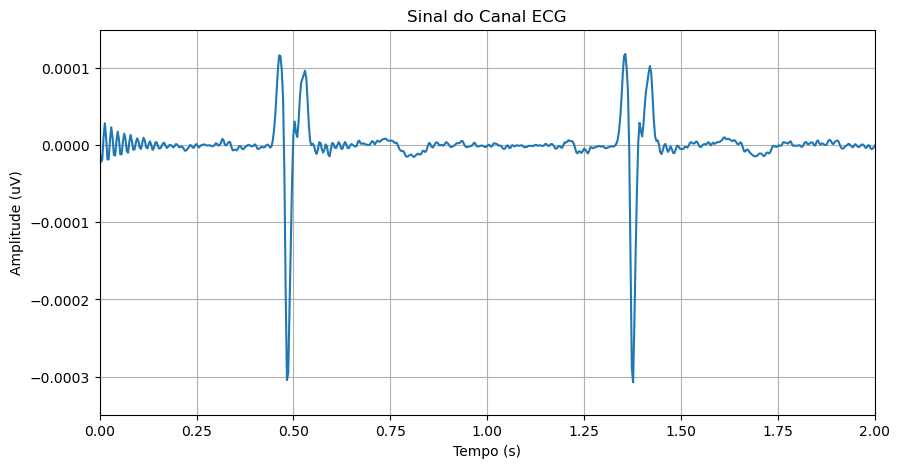

In [66]:
# Selecionar o 24º canal (índice 23), supostamente o sinal ECG em todos os arquivos (verificar)
channel_index = 23
channel_data = raw_data.get_data(picks=channel_index)


# Nome do canal para referência e verificação
channel_name = raw_data.ch_names[channel_index]
print(f"Nome do canal selecionado: {channel_name}")

# Plotar o 24º canal
import matplotlib.pyplot as plt

# Usaremos o narray times como vetor de tempo para o eixo x
plt.figure(figsize=(10, 5))
plt.plot(times, channel_data.T)  # Transposta para alinhar dimensões
plt.title(f'Sinal do Canal {channel_name}')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude (uV)')
plt.grid()
plt.xlim(0,2) #Para melhor visualização, limitarei a janela de 0 a 2s
plt.show()


# Explicação do método find_peaks:

1. height: Define a altura mínima para considerar um pico. Ajuste conforme o seu sinal ECG.
2. distance: Garante que os picos detectados estejam separados por um tempo mínimo (em amostras). No caso, usamos distancia_amostral = sfreq × 0.5, assumindo que o intervalo R-R mínimo é de 500 ms.
3. np.diff: Calcula as diferenças consecutivas no array de tempos dos picos R para obter os intervalos R-R.
4. find_peaks: returns Indices of peaks in the signal array that satisfy all given conditions.

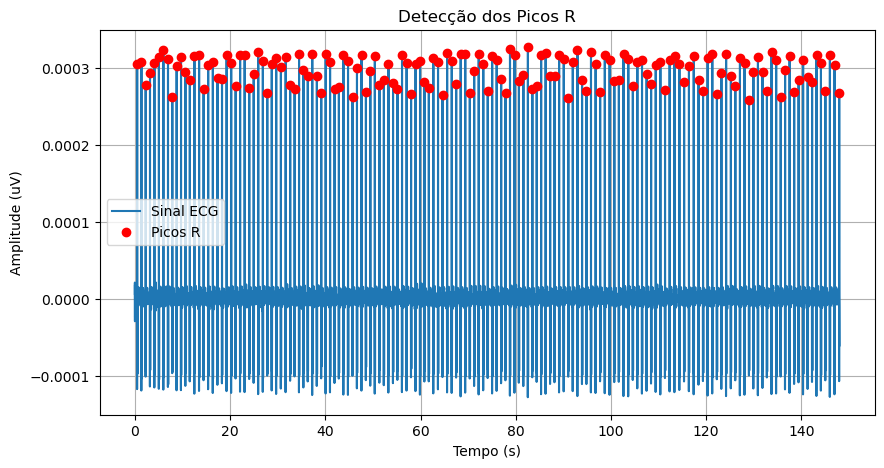

Primeiros intervalos R-R (em segundos): [0.89333333 0.89       0.91       0.93       0.94       0.94666667
 0.96333333 0.90666667 0.91       0.92      ]


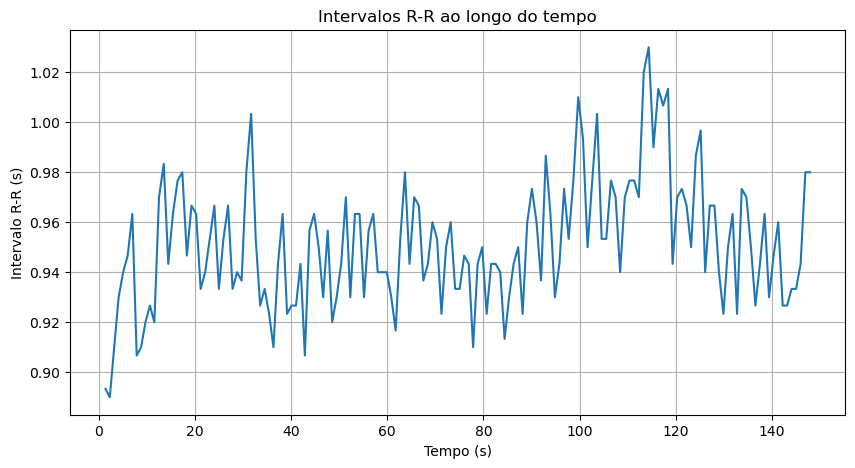

In [68]:
from scipy.signal import find_peaks
import numpy as np

#Desta vez o sinal ECG veio invertido (ver acima). Ajustar conforme necessidade. 
channel_data = (-1)*channel_data

# Dados do canal ECG (24º canal)
ecg_signal = channel_data[0]  # O sinal é 1D, obtido de channel_data
sfreq = raw_data.info['sfreq']  # Frequência de amostragem (Hz)

# Detectar os picos R. Observe que precisamos somente da localização dos picos.
peaks, _ = find_peaks(ecg_signal, height=0.0002, distance=sfreq*0.5)  # Ajustar 'height' conforme necessário

# Calcular os intervalos entre os picos R
r_peak_times = peaks / sfreq  # Convertendo índices para tempos (em segundos)
r_intervals = np.diff(r_peak_times)  # Array de Diferenças consecutivas


# Visualizar os picos R detectados
plt.figure(figsize=(10, 5))
plt.plot(times, ecg_signal, label='Sinal ECG')
plt.plot(r_peak_times, ecg_signal[peaks], 'ro', label='Picos R')
plt.title('Detecção dos Picos R')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude (uV)')
plt.legend()
plt.grid()
plt.show()

# Exibir os primeiros intervalos R-R
print("Primeiros intervalos R-R (em segundos):", r_intervals[:10])

# Nova série temporal: distâncias entre picos R
plt.figure(figsize=(10, 5))
plt.plot(r_peak_times[1:], r_intervals) #o tempo do primeiro pico (indice 0) é descartado no eixo x
plt.title('Intervalos R-R ao longo do tempo')
plt.xlabel('Tempo (s)')
plt.ylabel('Intervalo R-R (s)')
plt.grid()
plt.show()


# Topology of time series
From now on we explore how giotto-tda can be used to gain insights from time-varying data by using ideas from dynamical systems and persistent homology.


## Useful references

WEbsite: https://giotto-ai.github.io/gtda-docs/0.3.1/notebooks/topology_time_series.html

Topological Methods for the Analysis of Data by Jose Perea

The sliding window notebooks from Chris Tralie’s TDALabs

Detection of gravitational waves using topological data analysis and convolutional neural network: An improved approach by Christopher Bresten and Jae-Hun Jung. 

In [70]:
from gtda.time_series import SingleTakensEmbedding
from gtda.plotting import plot_point_cloud
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True) #não precisa estar conectado à internet para criar e visualizar os gráficos.(opcional)


#Instanciamento do objeto
embedder = SingleTakensEmbedding(
    parameters_type="fixed", #não utiliza de algoritmos internos para calcular valores óptimos de dimensao e delay.
    time_delay=1,
    dimension=2,
    stride=1,
)

embedded_r_intervals = embedder.fit_transform(r_intervals)
plot_point_cloud(embedded_r_intervals)


In [71]:
embedded_r_intervals

array([[0.89333333, 0.89      ],
       [0.89      , 0.91      ],
       [0.91      , 0.93      ],
       [0.93      , 0.94      ],
       [0.94      , 0.94666667],
       [0.94666667, 0.96333333],
       [0.96333333, 0.90666667],
       [0.90666667, 0.91      ],
       [0.91      , 0.92      ],
       [0.92      , 0.92666667],
       [0.92666667, 0.92      ],
       [0.92      , 0.97      ],
       [0.97      , 0.98333333],
       [0.98333333, 0.94333333],
       [0.94333333, 0.96333333],
       [0.96333333, 0.97666667],
       [0.97666667, 0.98      ],
       [0.98      , 0.94666667],
       [0.94666667, 0.96666667],
       [0.96666667, 0.96333333],
       [0.96333333, 0.93333333],
       [0.93333333, 0.94      ],
       [0.94      , 0.95333333],
       [0.95333333, 0.96666667],
       [0.96666667, 0.93333333],
       [0.93333333, 0.95333333],
       [0.95333333, 0.96666667],
       [0.96666667, 0.93333333],
       [0.93333333, 0.94      ],
       [0.94      , 0.93666667],
       [0.

In [72]:
#Temos que colocar a nuvem de pontos em um formato que a classe VietorisRipsPersistence aceite
embedded_r_intervals = embedded_r_intervals[None, :, :] #array tridimensional com primeira dimensao trivial

In [73]:
from gtda.homology import VietorisRipsPersistence
homology_dimensions = [0, 1, 2]
patient_persistence = VietorisRipsPersistence(homology_dimensions=homology_dimensions, infinity_values = None)
print("Persistence diagram for ECG signal")
persistence_diagram = patient_persistence.fit_transform_plot(embedded_r_intervals)


Persistence diagram for ECG signal


In [74]:
persistence_diagram # Terceira posição no array é a homologia (0, 1 ou 2) do ponto.

array([[[0.00000000e+00, 1.49011612e-08, 0.00000000e+00],
        [0.00000000e+00, 3.33333341e-03, 0.00000000e+00],
        [0.00000000e+00, 3.33333341e-03, 0.00000000e+00],
        [0.00000000e+00, 3.33333341e-03, 0.00000000e+00],
        [0.00000000e+00, 3.33333341e-03, 0.00000000e+00],
        [0.00000000e+00, 3.33333341e-03, 0.00000000e+00],
        [0.00000000e+00, 3.33333341e-03, 0.00000000e+00],
        [0.00000000e+00, 3.33333341e-03, 0.00000000e+00],
        [0.00000000e+00, 3.33333341e-03, 0.00000000e+00],
        [0.00000000e+00, 3.33333341e-03, 0.00000000e+00],
        [0.00000000e+00, 3.33333341e-03, 0.00000000e+00],
        [0.00000000e+00, 3.33333341e-03, 0.00000000e+00],
        [0.00000000e+00, 3.33333341e-03, 0.00000000e+00],
        [0.00000000e+00, 3.33333341e-03, 0.00000000e+00],
        [0.00000000e+00, 3.33333341e-03, 0.00000000e+00],
        [0.00000000e+00, 3.33333341e-03, 0.00000000e+00],
        [0.00000000e+00, 3.33333341e-03, 0.00000000e+00],
        [0.000

# Salvando os dados em um arquivo do tipo .json

### Salvaremos os dados do diagrama de persistência junto com o nome do arquivo .edf em um único arquivo, de forma acumulativa, para que, ao rodar o programa diversas vezes, os resultados sejam armazenados corretamente.

### Usaremos o formato JSON para salvar os dados, pois ele permite guardar tanto o nome do arquivo quanto os dados do diagrama. Caso prefira outro formato (como CSV), é possível adaptar.

In [76]:
import json
import numpy as np

# Função para salvar dados de forma acumulativa
def save_persistence_data(filename, persistence_diagram, output_file="persistence_results.json"):
    # Converta o diagrama para uma lista (JSON não suporta arrays do NumPy diretamente)
    persistence_data = persistence_diagram.tolist()
    
    # Crie um dicionário com os resultados
    entry = {"file": filename, "diagram": persistence_data}
    
    try:
        # Tente carregar dados existentes
        with open(output_file, "r") as f:
            data = json.load(f)
    except FileNotFoundError:
        # Se o arquivo ainda não existir, comece com uma lista vazia
        data = []

    # Adicione os novos dados à lista existente
    data.append(entry)
    
    # Salve novamente no arquivo
    with open(output_file, "w") as f:
        json.dump(data, f, indent=4)
    
    print(f"Dados do arquivo {filename} salvos com sucesso em {output_file}!")




In [77]:
# Nome do arquivo atual
edf_file = r'Aloisio_LION_Baseline.OA_PROGRAMA_A_DESLIGADO.28-03-2022 14.57.29.edf'
# Salve os dados do diagrama de persistência
save_persistence_data(edf_file, persistence_diagram)

Dados do arquivo Aloisio_LION_Baseline.OA_PROGRAMA_A_DESLIGADO.28-03-2022 14.57.29.edf salvos com sucesso em persistence_results.json!
